In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import kagglehub

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

In [2]:
# Set seeds
seed_value = 0
torch.manual_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

Path to dataset files: /home/FYP/jtan586/.cache/kagglehub/datasets/shayanfazeli/heartbeat/versions/1


In [5]:
df_test = pd.read_csv(f"{path}/mitbih_test.csv", header=None)
df_train = pd.read_csv(f"{path}/mitbih_train.csv", header=None)

In [6]:
test_classes = df_test.iloc[:, -1].unique()
print(test_classes)


[0. 1. 2. 3. 4.]


##**EDA**

In [7]:
labels = {
    0: "Normal",
    1: "Artial Premature",
    2: "Premature ventricular contraction",
    3: "Fusion of ventricular and normal",
    4: "Fusion of paced and normal"
}


/tmp/ipykernel_2621911/2186378379.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=train_counts.index, y=train_counts.values, palette=palette)
/tmp/ipykernel_2621911/2186378379.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{train_counts[i]}',


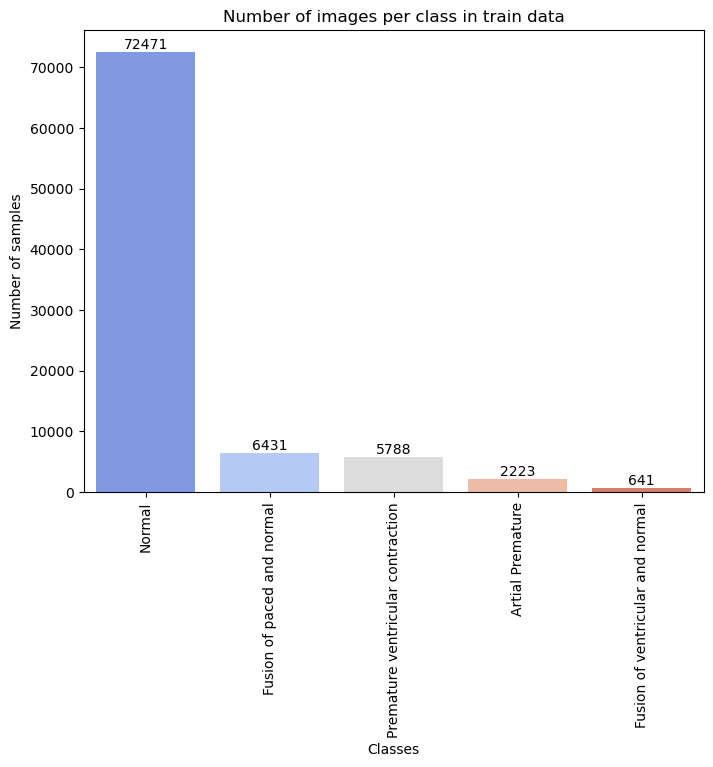

In [8]:
train_counts = df_train.iloc[:,-1].value_counts().rename(labels)

palette = sns.color_palette("coolwarm", len(train_counts))

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=train_counts.index, y=train_counts.values, palette=palette)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{train_counts[i]}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

plt.title('Number of images per class in train data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()


/tmp/ipykernel_2621911/1432594910.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=test_counts.index, y=test_counts.values, palette=palette)
/tmp/ipykernel_2621911/1432594910.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(f'{test_counts[i]}',


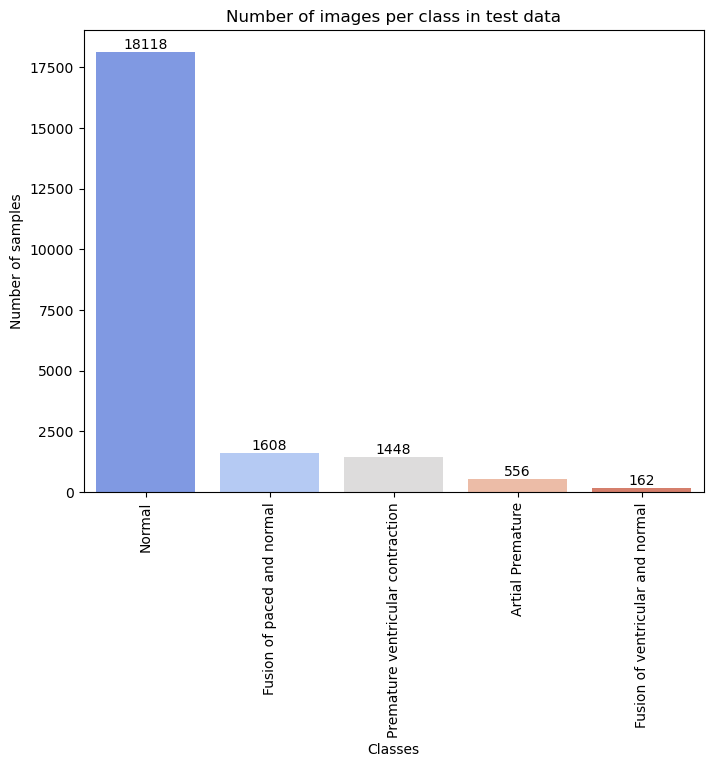

In [9]:
test_counts = df_test.iloc[:,-1].value_counts().rename(labels)

palette = sns.color_palette("coolwarm", len(test_counts))

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=test_counts.index, y=test_counts.values, palette=palette)

# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    ax.annotate(f'{test_counts[i]}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=10)

plt.title('Number of images per class in test data')
plt.xlabel('Classes')
plt.ylabel('Number of samples')
plt.xticks(rotation=90)
plt.show()

Data Preprocessing


In [10]:
# Separate features and labels
X_train = df_train.iloc[:, :-1].values  # Exclude label
y_train = df_train.iloc[:, -1].values   # Labels

X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Split the training data into new training and validation sets
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)



# Reshape the data for LSTM (samples, timesteps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
print(X_train_scaled.shape)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


print(f"New Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")

(70043, 187, 1)
New Training set size: 70043
Validation set size: 17511
Test set size: 21892


In [11]:
y_train.size()

torch.Size([70043])

In [12]:
train_loader = DataLoader(dataset=X_train, batch_size=32, shuffle=True)
train_loader.dataset.size

16372598

In [13]:
class RNN(nn.Module):
    def __init__(self, n_in, n_hidden, num_layers, n_out):
        super(RNN, self).__init__()

        # self.rnn = nn.RNN(n_in, n_hidden, batch_first=True) # add num_layers

        self.lstm = nn.LSTM(n_in, n_hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_out)

    def forward(self, x):

        out, (hn, cn) = self.lstm(x)

        # h0 = torch.zeros(1, x.size(0), n_hidden).to(x.device)
        # out, _ = self.rnn(x, h0)

        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [14]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
  size = len(train_dataloader.dataset)
  num_batches = len(train_dataloader)
  train_loss, train_correct = 0, 0

  for batch, (X, y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)

    outputs = model(X)
    loss = loss_fn(outputs, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    train_correct += (predicted == y).sum().item()

  train_loss /= num_batches
  train_correct /= size

  return train_loss, train_correct

def test_loop(test_dataloader, model, loss_fn):
  size = len(test_dataloader.dataset)
  num_batches = len(test_dataloader)
  test_loss, test_correct = 0, 0

  with torch.no_grad():
    for X, y in test_dataloader:
      X = X.to(device)
      y = y.to(device)

      outputs = model(X)
      test_loss += loss_fn(outputs, y).item()

      _, predicted = torch.max(outputs.data, 1)
      test_correct += (predicted == y).sum().item()

  test_loss /= num_batches
  test_correct /= size

  return test_loss, test_correct

In [15]:
class EarlyStopper:
  def __init__(self, patience=3, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
    if validation_loss < self.min_validation_loss:
      self.min_validation_loss = validation_loss
      self.counter = 0
    elif validation_loss > (self.min_validation_loss + self.min_delta):
      self.counter += 1
      if self.counter >= self.patience:
        return True
    return False


In [16]:
input_size = 1

n_hidden = 128
num_classes = 5
num_layers = 1

patience = 3
no_epochs = 50
batch_size = 32
lr = 0.001

In [17]:
def train(model, x_train, y_train, x_test, y_test, batch_size):
  train_losses, train_accuracies = [], []
  test_losses, test_accuracies = [], []

  early_stopper = EarlyStopper(patience=patience, min_delta=0)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  # Convert data to TensorDataset for DataLoader
  train_dataset = TensorDataset(x_train, y_train)
  test_dataset = TensorDataset(x_test, y_test)

  # Loaders for batching
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  for epoch in range(no_epochs):
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_loader, model, loss_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_correct)
    test_losses.append(test_loss)
    test_accuracies.append(test_correct)

    print(f"Epoch {epoch+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*test_correct):>0.2f}%, Val_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
      print('Done')
      break

  return train_accuracies, train_losses, test_accuracies, test_losses

In [18]:
model = RNN(input_size, n_hidden, num_layers, num_classes)
model.to(device)


RNN(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [19]:
train_accuracies, train_losses, val_accuracies, val_losses = train(model, X_train_scaled, y_train, X_val, y_val, batch_size)

Epoch 1: Train_accuracy: 82.65%, Train_loss: 0.665684, Val_accuracy: 83.16%, Val_loss: 0.639675
Epoch 2: Train_accuracy: 82.65%, Train_loss: 0.654946, Val_accuracy: 83.26%, Val_loss: 0.643252
Epoch 3: Train_accuracy: 82.67%, Train_loss: 0.647082, Val_accuracy: 83.32%, Val_loss: 0.626523
Epoch 4: Train_accuracy: 82.66%, Train_loss: 0.649846, Val_accuracy: 83.25%, Val_loss: 0.647012
Epoch 5: Train_accuracy: 82.64%, Train_loss: 0.656440, Val_accuracy: 83.26%, Val_loss: 0.642501
Epoch 6: Train_accuracy: 82.67%, Train_loss: 0.648855, Val_accuracy: 83.26%, Val_loss: 0.624053
Epoch 7: Train_accuracy: 82.59%, Train_loss: 0.637013, Val_accuracy: 83.30%, Val_loss: 0.613958
Epoch 8: Train_accuracy: 82.61%, Train_loss: 0.642553, Val_accuracy: 83.26%, Val_loss: 0.643004
Epoch 9: Train_accuracy: 82.65%, Train_loss: 0.656084, Val_accuracy: 83.26%, Val_loss: 0.633579
Epoch 10: Train_accuracy: 82.67%, Train_loss: 0.643141, Val_accuracy: 83.17%, Val_loss: 0.621194
Done


In [20]:
loss_fn = nn.CrossEntropyLoss()

x_test = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Convert data to TensorDataset for DataLoader
test_dataset = TensorDataset(x_test, y_test)


# Loaders for batching
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_loss, test_accuracy = test_loop(test_loader, model, loss_fn)
print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

Test accuracy: 82.67%, Test loss: 0.636445


In [21]:
def get_predictions(model, test_loader, device):
  model.eval()  # Set model to evaluation mode
  predictions = []  # List to store predictions

  with torch.no_grad():  # Disable gradient calculation
    for inputs, _ in test_loader:  # We don't need labels for predictions
      # Move inputs to the correct device
      inputs = inputs.to(device)

      # Forward pass
      outputs = model(inputs)

      # Get predicted class labels
      _, predicted = torch.max(outputs, 1)

      # Append predictions to the list
      predictions.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy

  return predictions

# Get predictions for the test set
test_predictions = get_predictions(model, test_loader, device)

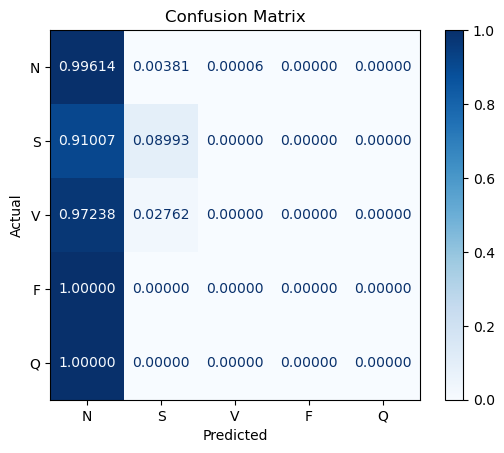

In [22]:
actual_labels = y_test.tolist()

class_labels = ["N", "S", "V", "F", "Q"]

cm = confusion_matrix(actual_labels, test_predictions, labels=[0,1,2,3,4])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".5f")

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [23]:
report = classification_report(actual_labels, test_predictions, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.83      1.00      0.91     18118
           S       0.31      0.09      0.14       556
           V       0.00      0.00      0.00      1448
           F       0.00      0.00      0.00       162
           Q       0.00      0.00      0.00      1608

    accuracy                           0.83     21892
   macro avg       0.23      0.22      0.21     21892
weighted avg       0.70      0.83      0.75     21892



/tc1apps/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tc1apps/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tc1apps/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SMOTE

In [24]:
smote_over_sampler = SMOTE()
x_resampled, y_resampled = smote_over_sampler.fit_resample(df_train.iloc[:, :-1], df_train.iloc[:,-1])

In [25]:
x_resampled.shape

(362355, 187)

In [26]:
y_resampled.value_counts()

187
0.0    72471
1.0    72471
2.0    72471
3.0    72471
4.0    72471
Name: count, dtype: int64

In [27]:
# Separate features and labels

# Scailing the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(x_resampled)
y_train = y_resampled.values


# Split the training data into new training and validation sets
X_train_scaled, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)



# Reshape the data for RNN/LSTM/GRU (samples, timesteps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
print(X_train_scaled.shape)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)


print(f"New Training set size: {X_train_scaled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test_scaled.shape[0]}")


(289884, 187, 1)
New Training set size: 289884
Validation set size: 72471
Test set size: 21892


In [28]:
smote_model = RNN(input_size, n_hidden, num_layers, num_classes)
smote_model.to(device)

RNN(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [29]:
train_accuracies, train_losses, val_accuracies, val_losses = train(smote_model, X_train_scaled, y_train, X_val, y_val, batch_size)

torch.save(smote_model.state_dict(), 'smote_rnn.pth')


Epoch 1: Train_accuracy: 40.28%, Train_loss: 1.363592, Val_accuracy: 52.50%, Val_loss: 1.152874
Epoch 2: Train_accuracy: 48.79%, Train_loss: 1.223455, Val_accuracy: 50.66%, Val_loss: 1.229387
Epoch 3: Train_accuracy: 56.08%, Train_loss: 1.038689, Val_accuracy: 54.62%, Val_loss: 1.198256
Epoch 4: Train_accuracy: 63.23%, Train_loss: 0.917915, Val_accuracy: 82.72%, Val_loss: 0.504465
Epoch 5: Train_accuracy: 86.56%, Train_loss: 0.373750, Val_accuracy: 89.96%, Val_loss: 0.288355
Epoch 6: Train_accuracy: 90.94%, Train_loss: 0.254701, Val_accuracy: 92.64%, Val_loss: 0.205747
Epoch 7: Train_accuracy: 93.41%, Train_loss: 0.189065, Val_accuracy: 94.87%, Val_loss: 0.152904
Epoch 8: Train_accuracy: 94.82%, Train_loss: 0.150528, Val_accuracy: 95.73%, Val_loss: 0.124483
Epoch 9: Train_accuracy: 95.77%, Train_loss: 0.124461, Val_accuracy: 95.79%, Val_loss: 0.126033
Epoch 10: Train_accuracy: 96.32%, Train_loss: 0.108226, Val_accuracy: 96.66%, Val_loss: 0.099612
Epoch 11: Train_accuracy: 96.46%, Train

In [30]:
loss_fn = nn.CrossEntropyLoss()

test_loss, test_accuracy = test_loop(test_loader, smote_model, loss_fn)
print(f"Test accuracy: {(100*test_accuracy):>0.2f}%, Test loss: {test_loss:>8f}")

Test accuracy: 97.21%, Test loss: 0.097882


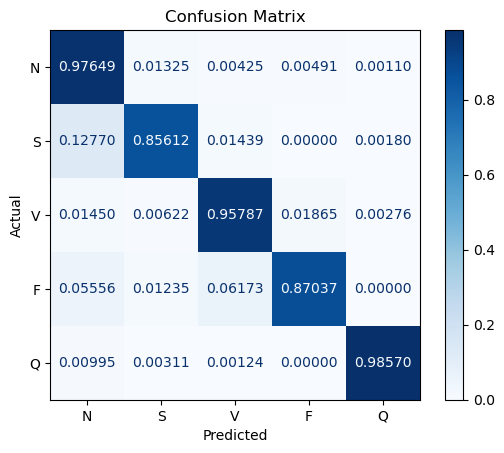

In [31]:
test_predictions = get_predictions(smote_model, test_loader, device)
actual_labels = y_test.tolist()

class_labels = ["N", "S", "V", "F", "Q"]

cm = confusion_matrix(actual_labels, test_predictions, labels=[0,1,2,3,4])

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format=".5f")

plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [33]:
report = classification_report(actual_labels, test_predictions, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           N       0.99      0.98      0.98     18118
           S       0.65      0.86      0.74       556
           V       0.93      0.96      0.95      1448
           F       0.55      0.87      0.67       162
           Q       0.98      0.99      0.99      1608

    accuracy                           0.97     21892
   macro avg       0.82      0.93      0.87     21892
weighted avg       0.98      0.97      0.97     21892

